In [97]:
import pandas as pd
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [70]:
data = pd.read_csv('cyber_bully_cleaned.csv')
data.head()
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,tweet_text,cyberbullying_type
0,word katandandre food crapilicious mkr,not_cyberbullying
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying
2,xochitlsuckkks classy whore red velvet cupcake,not_cyberbullying
3,meh thanks head concerned another angry dude t...,not_cyberbullying
4,rudhoeenglish isi account pretending kurdish a...,not_cyberbullying


In [80]:
label_map = {i : l for i, l in enumerate(data['cyberbullying_type'].unique())}
label_map  
data['label'] = data['cyberbullying_type'].map({l : i for i, l in label_map.items()})
data.head()

,tweet_text,cyberbullying_type,label
0,word katandandre food crapilicious mkr,not_cyberbullying,0
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying,0
2,xochitlsuckkks classy whore red velvet cupcake,not_cyberbullying,0
3,meh thanks head concerned another angry dude t...,not_cyberbullying,0
4,rudhoeenglish isi account pretending kurdish a...,not_cyberbullying,0


In [72]:
unique_words = set()

for i, tweet in enumerate(data["tweet_text"]):
    for word in tweet.split():
        unique_words.add(word)

print(len(unique_words))
        

44005


### Word2Vec

In [7]:
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

In [73]:
for word in list(unique_words):
    if word not in word2vec_model.key_to_index:
        unique_words.remove(word)
        
print(len(unique_words))

22276


In [74]:
embedding_matrix =[[0] * 300] #this matrix will contain the word embeddings for the top 5000 words #the first row will be the embedding for the padding token which is 0
word_indices = {} #this dictionary will map each word to its index in the embedding matrix, this is needed when we train the neural network, the input to the neural network will be the index of the word in the embedding matrix
idx = 1
for i, word in enumerate(unique_words):
    if word in word2vec_model.key_to_index:
        embedding_matrix.append(word2vec_model[word])
        word_indices[word] = idx
        idx += 1
    
    else:
        continue
embedding_matrix = np.array(embedding_matrix)
print(embedding_matrix.shape)

(22277, 300)


In [82]:
def padding(sequence, max_len):
    if len(sequence) <= max_len:
        sequence = sequence + [0] * (max_len - len(sequence)) 
    
    elif len(sequence) > max_len:
        sequence = sequence[:max_len]
    
    return sequence

def prepare_data(df, word_indices, max_len):
    X = []
    y = []
    for i, row in df.iterrows():
        sequence = [word_indices[word] for word in row["tweet_text"].split() if word in word_indices and word in word2vec_model.key_to_index]
        sequences = padding(sequence, max_len)
        X.append(sequences)
        y.append(row["label"])
    
    X = torch.tensor(X).clone().detach()
    y = torch.tensor(y).float().clone().detach()
    return X, y

In [115]:
train_size = 0.7
test_size = 0.2
val_size = 0.1

X, y = prepare_data(data, word_indices, 50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size/(test_size + val_size), random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Models

In [150]:
#LSTM 
class LSTMClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(LSTMClf, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        # self.embedding.load_state_dict({'weight': torch.FloatTensor(embedding_matrix)})
        # self.embedding.weight.requires_grad = False #freeze the embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device
        
    def forward(self, x):
        #randomly initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        out = self.embedding(x)
        out, _ = self.lstm(out, (h0, c0))
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)
    
    
class CNNClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, embedding_matrix):
        super(CNNClf, self).__init__()
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.load_state_dict({'weight': torch.FloatTensor(embedding_matrix)})
        self.embedding.weight.requires_grad = False
        
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3) #output size = (input_size - kernel_size + 1) = (300 - 3 + 1) = 298 
        
        self.fc = nn.Linear(hidden_size * 298, 64)  # 298 is the output size of the convolutional layer
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

        
    def forward(self, x):
        out = self.embedding(x)
        out = self.conv1(out).relu()
        out = out.flatten(1)
        out = self.fc(out).relu()
        out = self.fc2(out).relu()
        out = self.fc3(out)
        return F.log_softmax(out, dim=0)
    
    
class BiLSTMClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(BiLSTMClf, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.load_state_dict({'weight': torch.FloatTensor(embedding_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True) 
        self.fc = nn.Linear(hidden_size * 2, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0  = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        
        out = self.embedding(x)
        out, _ = self.lstm(out, (h0, c0)) 
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)

In [160]:
def train(train_data, validation_data, criterion, optimizer, device, model, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        train_corr = 0
        total_train = 0

        for x, y in train_data:
            # Send data to the correct device
            x, y = x.to(device), y.to(device).long()
            total_train += y.size(0)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item() 

            #Compute train accuracy
            pred = torch.argmax(output, 1)
            train_corr += (pred == y).sum().item()
            
            loss.backward()
            optimizer.step()
        
        train_losses.append(total_loss / len(train_data))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in validation_data:
                x, y = x.to(device), y.to(device).long()
                output = model(x)
                val_loss += criterion(output, y).item()
            
            val_losses.append(val_loss / len(validation_data))
        
        # #Display metrics
        train_accuracy = 100 * train_corr / total_train
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_losses[-1]:.4f}")


    return train_losses, val_losses


def test(test_data, model, device):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for x, y in test_data:
            x, y = x.to(device), y.to(device).long()
            output = model(x)
            pred = torch.argmax(output, 1)
            
            # Collect predictions and true labels as lists of integers
            y_pred.extend(pred.int().cpu().tolist())
            y_true.extend(y.int().cpu().tolist())

    # Ensure that y_true is the first argument in the metric functions
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

In [166]:
#hyperparameters
input_size = 300
hidden_size = 16
num_layers = 2
num_classes = 5
learning_rate = 0.0006
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.NLLLoss()
dl_results = {} #store the results of the different models


cuda


Training LSTMClf
Epoch 1/20, Training Loss: 3.4617, Train Accuracy: 20.24%, Validation Loss: 3.4652
Epoch 2/20, Training Loss: 3.4617, Train Accuracy: 20.19%, Validation Loss: 3.4652
Epoch 3/20, Training Loss: 3.4617, Train Accuracy: 20.12%, Validation Loss: 3.4649
Epoch 4/20, Training Loss: 3.0284, Train Accuracy: 38.45%, Validation Loss: 2.9865
Epoch 5/20, Training Loss: 2.9574, Train Accuracy: 39.67%, Validation Loss: 2.9552
Epoch 6/20, Training Loss: 2.8226, Train Accuracy: 49.49%, Validation Loss: 2.6033
Epoch 7/20, Training Loss: 2.4980, Train Accuracy: 70.98%, Validation Loss: 2.5020
Epoch 8/20, Training Loss: 2.3182, Train Accuracy: 84.20%, Validation Loss: 2.2982
Epoch 9/20, Training Loss: 2.1506, Train Accuracy: 93.91%, Validation Loss: 2.3073
Epoch 10/20, Training Loss: 2.1030, Train Accuracy: 95.42%, Validation Loss: 2.2782
Epoch 11/20, Training Loss: 2.0984, Train Accuracy: 95.59%, Validation Loss: 2.3772
Epoch 12/20, Training Loss: 2.0747, Train Accuracy: 96.44%, Validati

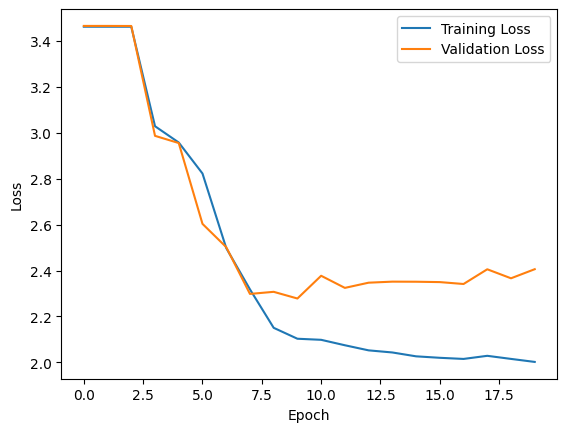

In [167]:
lstm_clf = LSTMClf(input_size, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = lstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
    

Training CNNClf
Epoch 1/20, Training Loss: 2.3430, Train Accuracy: 87.22%, Validation Loss: 2.1720
Epoch 2/20, Training Loss: 2.1626, Train Accuracy: 91.25%, Validation Loss: 2.1635
Epoch 3/20, Training Loss: 2.1345, Train Accuracy: 92.01%, Validation Loss: 2.1436
Epoch 4/20, Training Loss: 2.1106, Train Accuracy: 92.67%, Validation Loss: 2.1468
Epoch 5/20, Training Loss: 2.0941, Train Accuracy: 93.35%, Validation Loss: 2.1390
Epoch 6/20, Training Loss: 2.0756, Train Accuracy: 93.91%, Validation Loss: 2.1671
Epoch 7/20, Training Loss: 2.0573, Train Accuracy: 94.73%, Validation Loss: 2.1534
Epoch 8/20, Training Loss: 2.0363, Train Accuracy: 95.49%, Validation Loss: 2.1540
Epoch 9/20, Training Loss: 2.0184, Train Accuracy: 96.27%, Validation Loss: 2.1802
Epoch 10/20, Training Loss: 2.0024, Train Accuracy: 97.02%, Validation Loss: 2.1922
Epoch 11/20, Training Loss: 1.9877, Train Accuracy: 97.55%, Validation Loss: 2.2179
Epoch 12/20, Training Loss: 1.9755, Train Accuracy: 98.17%, Validatio

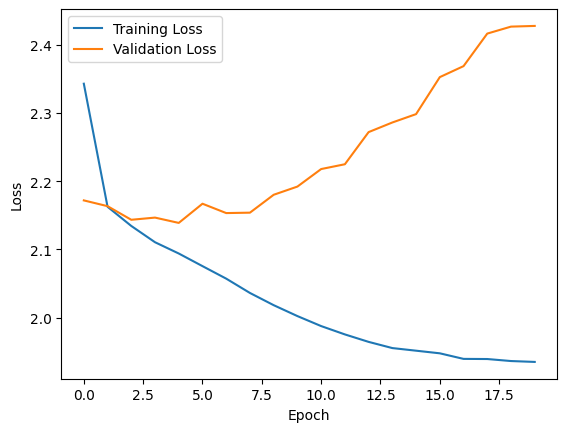

In [169]:
cnn_clf = CNNClf(50, hidden_size, num_classes, embedding_matrix).to(device)

model = cnn_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Training BiLSTMClf
Epoch 1/20, Training Loss: 3.2493, Train Accuracy: 34.70%, Validation Loss: 3.0300
Epoch 2/20, Training Loss: 2.9094, Train Accuracy: 55.24%, Validation Loss: 2.7484
Epoch 3/20, Training Loss: 2.7146, Train Accuracy: 66.52%, Validation Loss: 2.6549
Epoch 4/20, Training Loss: 2.8268, Train Accuracy: 61.41%, Validation Loss: 2.7212
Epoch 5/20, Training Loss: 2.6536, Train Accuracy: 70.32%, Validation Loss: 2.5791
Epoch 6/20, Training Loss: 2.6768, Train Accuracy: 66.73%, Validation Loss: 2.5936
Epoch 7/20, Training Loss: 2.5661, Train Accuracy: 71.70%, Validation Loss: 2.5614
Epoch 8/20, Training Loss: 2.6201, Train Accuracy: 67.04%, Validation Loss: 2.6293
Epoch 9/20, Training Loss: 2.5813, Train Accuracy: 70.99%, Validation Loss: 2.5309
Epoch 10/20, Training Loss: 2.5114, Train Accuracy: 75.85%, Validation Loss: 2.5752
Epoch 11/20, Training Loss: 2.4776, Train Accuracy: 78.80%, Validation Loss: 2.3846
Epoch 12/20, Training Loss: 2.3487, Train Accuracy: 85.10%, Valida

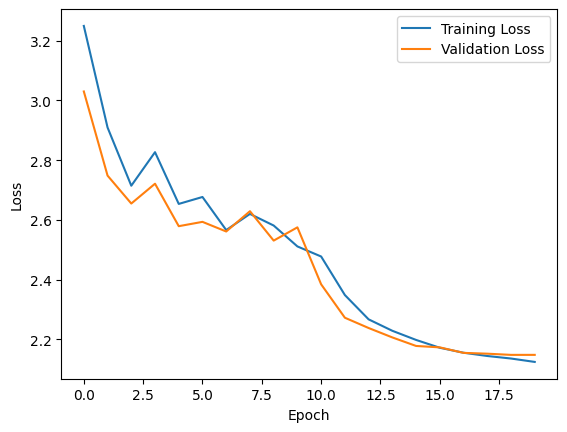

In [170]:
bi_lstm_clf = BiLSTMClf(input_size, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = bi_lstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()